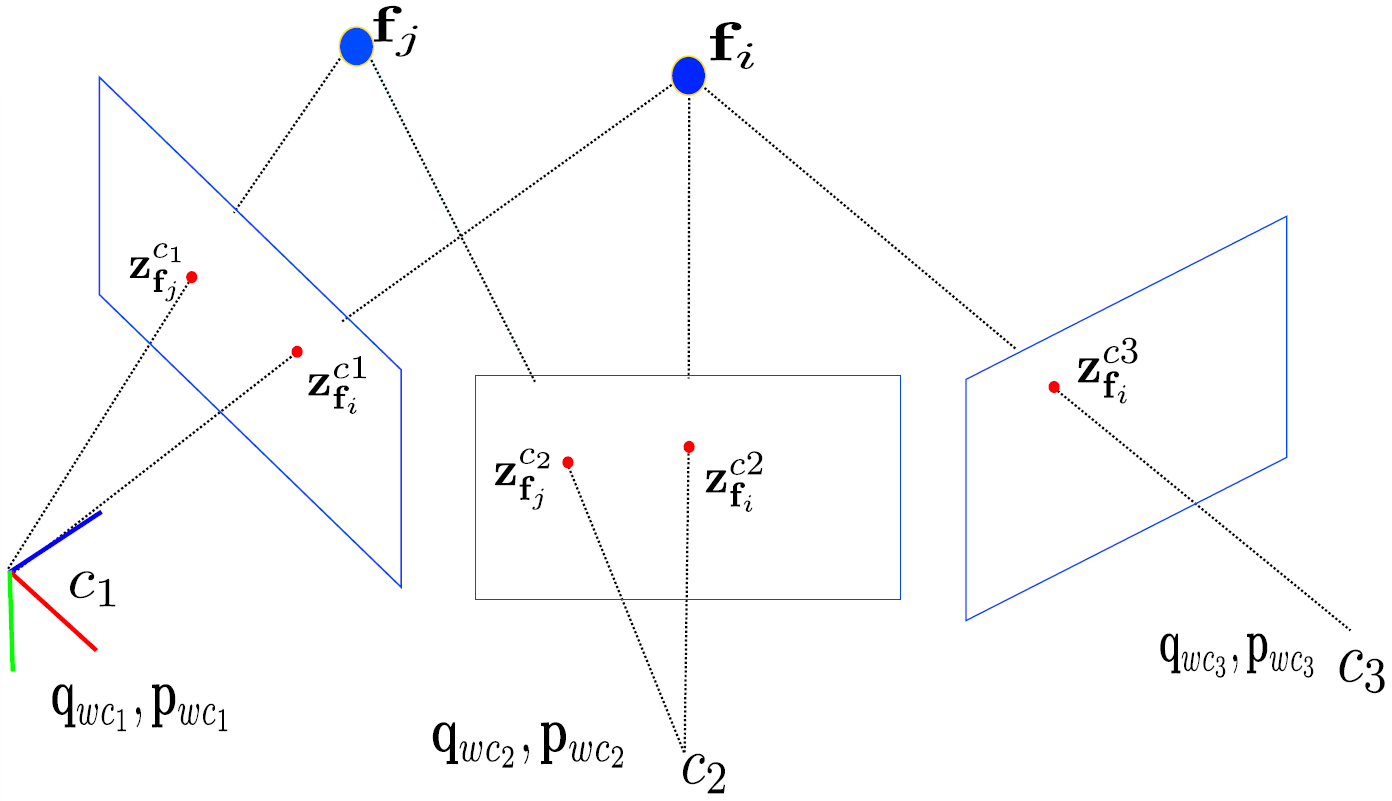

- **已知**
    -  状态量初始值: 特征点的三维坐标, 相机的位姿。
    - 系统测量值: 特征点在不同图像上的图像坐标。
- **问题**: 如何估计状态量的最优值？
- **解决**: 构建误差函数，利用最小二乘得到状态量的最优估计
$$
\mathop{\arg\min}\limits_{\textbf{q,p,f}} \sum_{i=1}^m \sum_{j=1}^n \left\| \pi(\textbf{q}_{wc_i}, \textbf{p}_{wc_i}, \textbf{f}_j) - \textbf{z}_{f_j}^{c_i} \right\|_{\sum_{ij}}
$$

符号 | 含义
:- | :-
$\textbf{q}$ | 旋转四元数
$\textbf{p}$ | 平移向量
$\textbf{f}$ | 特征点 3D 坐标
$c_i$ | 第$i$个相机系
$\pi(\cdot)$ | 投影函数
$\textbf{z}_{f_j}^{c_i}$ | $c_i$ 对 $f_j$ 的观测
$\sum_{ij}$ | $\sum$范数

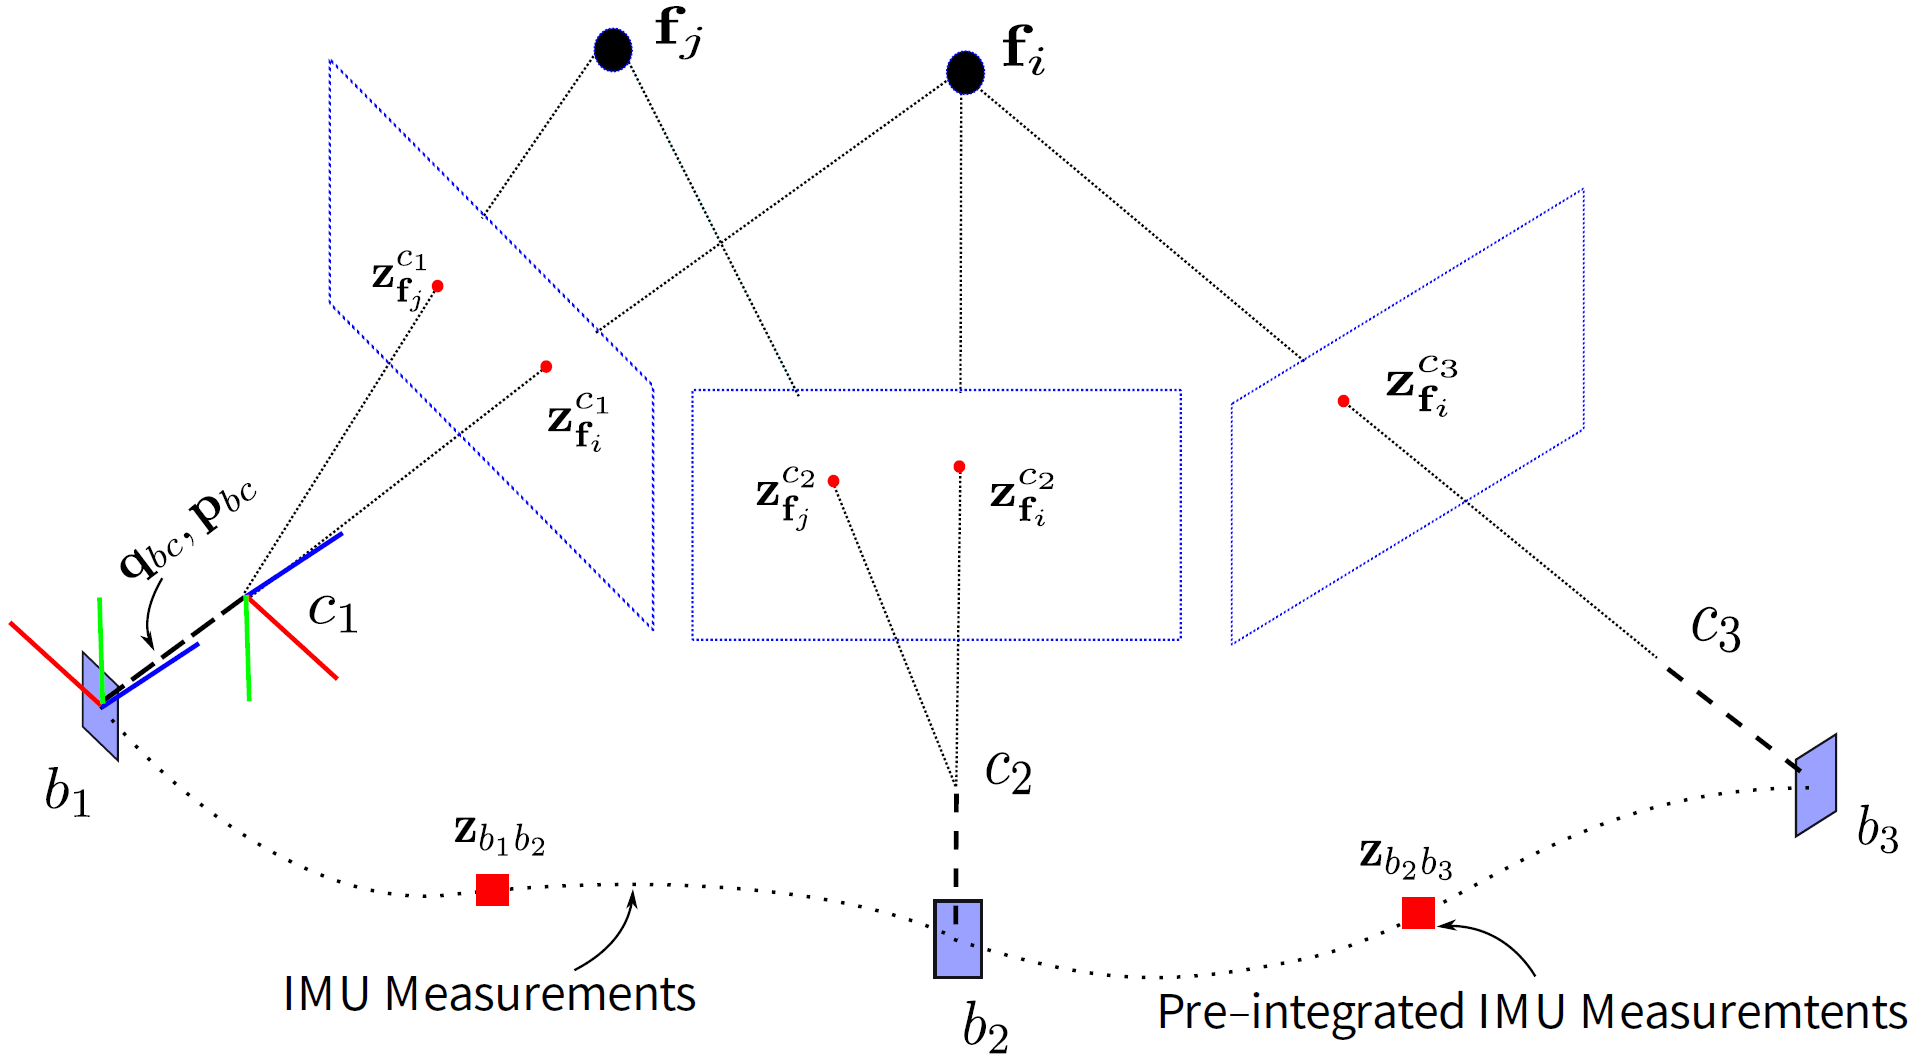

# 基于滑动窗口的 VIO Bundle Adjustment

$$ \min_{\mathcal{X}} 
\underbrace{\rho \left( \left\| \textbf{r}_p - \textbf{J}_p \mathcal{X} \right\|_{\sum_p}^2 \right)}_\text{prior} +
\underbrace{\sum_{i \in B} \rho \left( \left\| \textbf{r}_b \left( \textbf{z}_{b_i b_{i+1}}, \mathcal{X} \right) \right\|_{\sum_{b_i b_{i+1}}}^2 \right)}_\text{IMU error} + 
\underbrace{\sum_{(i,j) \in F} \rho \left( \left\| \textbf{r}_f \left( \textbf{z}_{f_j}^{c_i}, \mathcal{X} \right) \right\|_{\sum_{f_j}^{c_i}}^2 \right)}_\text{image error} $$
为了节约计算量采用滑动窗口形式的Bundle Adjustment, 在$i$时刻, 
滑动窗口内待优化的系统状态量定义如下:
$\begin{align}
X & = \left[ \textbf{x}_n, \textbf{x}_{n+1}, \dots, \textbf{x}_{n+N}, \lambda_m, \lambda_{m + 1}, \dots, \lambda_{m+M} \right] \\
\textbf{x}_i & = \left[\textbf{p}_{wb_i}, \textbf{v}_i^w, \textbf{q}_{wb_i}, \textbf{b}_a^{b_i}, \textbf{b}_g^{b_i} \right]^T, i \in [n, n + N]
\end{align}
\tag{20}$
其中:
- $\textbf{x}_i$ 包含$i$时刻 IMU 机体的在惯性坐标系中的位置($\textbf{p}_{wb_i}$), 速度($\textbf{v}_i^w$), 姿态($\textbf{q}_{wb_i}$), 以及IMU 机体坐标系中的加速度的偏置量估计($\textbf{b}_a^{b_i}$)和角速度的偏置量估计($\textbf{b}_g^{b_i}$)。
- $n$, $m$分别是机体状态量, 路标在滑动窗口里的起始时刻。
- $N$ 滑动窗口中关键帧数量。
- $M$ 是被滑动窗口内所有关键帧观测到的路标数量。



## VIO 中基于逆深度的重投影误差/残差
1. 视觉重投影残差为:
$$ \textbf{r}_c = \left[ \begin{matrix} \color{red}{\frac{x_{c_j}}{z_{c_j}}} - u_{c_j} \\ \color{red}{\frac{y_{c_j}}{z_{c_j}}} - v_{c_j} \end{matrix} \right] \tag{24}$$

>**定义**：一个特征点在归一化相机坐标系下的估计值与观测值的差。
$$ \textbf{r}_c = \left[ \begin{matrix} \frac{x}{z} - u \\ \frac{y}{z} - v \end{matrix} \right] \tag{21}$$
其中, 待估计的状态量为特征点的三维空间坐标 $(x, y, z)^T$，观测值$(u, v)^T$为特征在相机归一化平面的坐标。

2. 对于第$i$帧中的特征点, 它投影到第$j$帧相机坐标系下的值为:
$$ \left[ \begin{matrix} \color{red}{x_{c_j}} \\ \color{red}{y_{c_j}} \\ \color{red}{z_{c_j}} \\ 1 \end{matrix} \right] = T_{bc}^{-1} T_{wb_j}^{-1} T_{wb_i} T_{bc} \left[ \begin{matrix} \frac{1}{\lambda} u_{c_i} \\ \frac{1}{\lambda} v_{c_i} \\ \frac{1}{\lambda} \\ 1 \end{matrix} \right] \tag{23}$$

> 逆深度参数化$\lambda$<br>
特征点在归一化相机坐标系与在相机坐标系下的坐标关系为:
$$ \left[ \begin{matrix} x \\y \\ z \end{matrix} \right] = \frac{1}{\lambda} \left[ \begin{matrix} u \\ v \\ 1 \end{matrix} \right] \tag{22} $$
其中$\lambda = 1 / z$称为逆深度。

3. 拆成三维坐标形式为:
$$ \textbf{f}_{c_j} = \left[ \begin{matrix} \color{red}{x_{c_j}} \\ \color{red}{y_{c_j}} \\ \color{red}{z_{c_j}} \end{matrix} \right] = 
R_{bc}^{T} R_{wb_j}^{T} R_{wb_i} R_{bc} \frac{1}{\lambda} \left[ \begin{matrix} u_{c_i} \\ v_{c_i} \\ 1 \end{matrix} \right] + 
R_{bc}^{T} \left[ R_{wb_j}^{T} \left( R_{wb_i} \textbf{p}_{bc}  + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right] \tag{60}$$

> Proof:
$$\begin{align} 
\left[ \begin{matrix} \color{red}{\textbf{f}_{c_j}} \\ 1 \end{matrix} \right] & = T_{bc}^{-1} T_{wb_j}^{-1} T_{wb_i} T_{bc} \left[ \begin{matrix} \color{blue}{\frac{1}{\lambda} \mathscr{A}} \\ 1 \end{matrix} \right] \\ 
& = \left[ \begin{matrix} R_{bc} & \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right]^{-1} 
\left[ \begin{matrix} R_{wb_j} & \textbf{p}_{wb_j} \\ 0 & 1 \end{matrix} \right]^{-1}
\left[ \begin{matrix} R_{wb_i} & \textbf{p}_{wb_i} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} R_{bc} & \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} \color{blue}{\frac{1}{\lambda} \mathscr{A}} \\ 1 \end{matrix} \right] \\
& = \left[ \begin{matrix} R_{bc}^{-1} & -R_{bc}^{-1} \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right] 
\left[ \begin{matrix} R_{wb_j}^{-1} & -R_{wb_j}^{-1} \textbf{p}_{wb_j} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} R_{wb_i} & \textbf{p}_{wb_i} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} R_{bc} & \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} \color{blue}{\frac{1}{\lambda} \mathscr{A}} \\ 1 \end{matrix} \right] \\
& = \left[ \begin{matrix} R_{bc}^{-1} & -R_{bc}^{-1} \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right] 
\left[ \begin{matrix} R_{wb_j}^{-1} & -R_{wb_j}^{-1} \textbf{p}_{wb_j} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} R_{wb_i} & \textbf{p}_{wb_i} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} R_{bc} \color{blue}{\frac{1}{\lambda} \mathscr{A}} + \textbf{p}_{bc} \\ 1 \end{matrix} \right] \\
& = \left[ \begin{matrix} R_{bc}^{-1} & -R_{bc}^{-1} \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right] 
\left[ \begin{matrix} R_{wb_j}^{-1} & -R_{wb_j}^{-1} \textbf{p}_{wb_j} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} R_{wb_i} \left( R_{bc} \color{blue}{\frac{1}{\lambda} \mathscr{A}} + \textbf{p}_{bc} \right) + \textbf{p}_{wb_i} \\ 1 \end{matrix} \right] \\
& = \left[ \begin{matrix} R_{bc}^{-1} & -R_{bc}^{-1} \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right] 
\left[ \begin{matrix} R_{wb_j}^{-1} & -R_{wb_j}^{-1} \textbf{p}_{wb_j} \\ 0 & 1 \end{matrix} \right]
\left[ \begin{matrix} R_{wb_i} R_{bc} \color{blue}{\frac{1}{\lambda} \mathscr{A}} + R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} \\ 1 \end{matrix} \right] \\
& = \left[ \begin{matrix} R_{bc}^{-1} & -R_{bc}^{-1} \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right] 
\left[ \begin{matrix} R_{wb_j}^{-1} \left( R_{wb_i} R_{bc} \color{blue}{\frac{1}{\lambda} \mathscr{A}} + R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} \right) -R_{wb_j}^{-1} \textbf{p}_{wb_j} \\ 1 \end{matrix} \right] \\
& = \left[ \begin{matrix} R_{bc}^{-1} & -R_{bc}^{-1} \textbf{p}_{bc} \\ 0 & 1 \end{matrix} \right] 
\left[ \begin{matrix} R_{wb_j}^{-1} R_{wb_i} R_{bc} \color{blue}{\frac{1}{\lambda} \mathscr{A}} + R_{wb_j}^{-1} \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) \\ 1 \end{matrix} \right] \\
& = \left[ \begin{matrix} R_{bc}^{-1} \left[ R_{wb_j}^{-1} R_{wb_i} R_{bc} \color{blue}{\frac{1}{\lambda} \mathscr{A}} + R_{wb_j}^{-1} \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) \right] -R_{bc}^{-1} \textbf{p}_{bc} \\ 1 \end{matrix} \right] \\
& = \left[ \begin{matrix} R_{bc}^{-1} R_{wb_j}^{-1} R_{wb_i} R_{bc} \color{blue}{\frac{1}{\lambda} \mathscr{A}} + R_{bc}^{-1} \left[ R_{wb_j}^{-1} \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right] \\ 1 \end{matrix} \right] \\
\implies \color{red}{\textbf{f}_{c_j}} & = R_{bc}^{T} R_{wb_j}^{T} R_{wb_i} R_{bc} \color{blue}{\frac{1}{\lambda} \left[ \begin{matrix} u_{c_i} \\ v_{c_i} \\ 1 \end{matrix} \right]} + R_{bc}^{T} \left[ R_{wb_j}^{T} \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right]
\end{align}$$

## 视觉重投影残差的 Jacobian 推导
在推导各类 Jacobian 之前, 为了简化公式, 先定义如下变量:
$$\begin{align} \color{orange}{\textbf{f}_{b_i}} & = \textbf{R}_{bc} \textbf{f}_{c_i} + \textbf{p}_{bc} \tag{61.a} \\
\color{cyan}{\textbf{f}_w} & = \textbf{R}_{wb_i} \textbf{f}_{b_i} + \textbf{p}_{wb_i} \tag{61.b} \\
\color{limegreen}{\textbf{f}_{b_j}} & = \textbf{R}_{wb_j}^T \left( \textbf{f}_w - \textbf{p}_{wb_j} \right) \tag{61.c}
\end{align}$$
Jacobian 为视觉误差对两个时刻的状态量($\left[ \begin{matrix} \delta \textbf{p}_{wb_i} \\ \delta \textbf{q}_{wb_i} \end{matrix} \right]$, $\left[ \begin{matrix} \delta \textbf{p}_{wb_j} \\ \delta \textbf{q}_{wb_j} \end{matrix} \right]$), 外参$\left[ \begin{matrix} \delta \textbf{p}_{bc} \\ \delta \textbf{q}_{bc} \end{matrix} \right]$, 以及逆深度$\delta \lambda$求导:
$$\textbf{J} = \left[ \begin{matrix}
\frac{\partial \textbf{r}_c}{\partial \left[ \begin{matrix} \delta \textbf{p}_{wb_i} \\ \delta \textbf{q}_{wb_i} \end{matrix} \right]} &
\frac{\partial \textbf{r}_c}{\partial \left[ \begin{matrix} \delta \textbf{p}_{wb_j} \\ \delta \textbf{q}_{wb_j} \end{matrix} \right]} &
\frac{\partial \textbf{r}_c}{\partial \left[ \begin{matrix} \delta \textbf{p}_{bc} \\ \delta \textbf{q}_{bc} \end{matrix} \right]} &
\frac{\partial \textbf{r}_c}{\partial \delta \lambda}
\end{matrix} \right] \tag{62}$$
1. 误差$\textbf{r}_c = \left[ \begin{matrix} \frac{x_{c_j}}{z_{c_j}} - u_{c_j} \\ \frac{y_{c_j}}{z_{c_j}} - v_{c_j} \end{matrix} \right]$对$\color{red}{\textbf{f}_{c_j}}$求导:
$$ \frac{\partial \textbf{r}_c}{\partial \color{red}{\textbf{f}_{c_j}}} = \left[ \begin{matrix}
\frac{1}{z_{c_j}} & 0 & -\frac{x_{c_j}}{z_{c_j}^2} \\
0 & \frac{1}{z_{c_j}} & -\frac{y_{c_j}}{z_{c_j}^2}
\end{matrix} \right] \tag{63}$$

2. $\color{red}{\textbf{f}_{c_j}}$对各状态量求导:
    1. 对$i$时刻的状态量求导
        1. 对$i$时刻位移求导, 可直接写出如下:
$$\begin{align} 
\color{red}{\textbf{f}_{c_j}} & = R_{bc}^T R_{wb_j}^T R_{wb_i} R_{bc} \color{blue}{\textbf{f}_{c_i}} + R_{bc}^T \left[ R_{wb_j}^T \left( R_{wb_i} \textbf{p}_{bc} + \color{fuchsia}{\textbf{p}_{wb_i}} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right] \\
\implies \frac{\partial \color{red}{\textbf{f}_{c_j}}}{\partial \delta \color{fuchsia}{\textbf{p}_{wb_i}}} & = R_{bc}^T R_{wb_j}^T \tag{64} 
\end{align} $$
        2. 对$i$时刻角度增量求导
$$\begin{align} \color{red}{\textbf{f}_{c_j}} & = R_{bc}^T R_{wb_j}^T \color{fuchsia}{R_{wb_i}} R_{bc} \color{blue}{\textbf{f}_{c_i}} + R_{bc}^T \left[ R_{wb_j}^T \left( \color{fuchsia}{R_{wb_i}} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right] \tag{65} \\
& = R_{bc}^T R_{wb_j}^T \color{fuchsia}{R_{wb_i}} R_{bc} \color{blue}{\textbf{f}_{c_i}} + R_{bc}^T R_{wb_j}^T \color{fuchsia}{R_{wb_i}} \textbf{p}_{bc} + (\cdots) \\
& = R_{bc}^T R_{wb_j}^T \color{fuchsia}{R_{wb_i}} \left( R_{bc} \color{blue}{\textbf{f}_{c_i}} + \textbf{p}_{bc} \right) + (\cdots) \\
& = R_{bc}^T R_{wb_j}^T \color{fuchsia}{R_{wb_i}} \color{orange}{\textbf{f}_{b_i}} + (\cdots) \tag{66} \\
\implies \frac{\partial \color{red}{\textbf{f}_{c_j}}}{\partial \delta \color{fuchsia}{\textbf{q}_{wb_i}}} & = \frac{\partial R_{bc}^T R_{wb_j}^T \color{fuchsia}{R_{wb_i}}\left(I + [\delta \color{fuchsia}{\textbf{q}_{wb_i}}]_{\times} \right) \color{orange}{\textbf{f}_{b_i}}}{\partial \delta \color{fuchsia}{\textbf{q}_{wb_i}}} \\
& = - R_{bc}^T R_{wb_j}^T \color{fuchsia}{R_{wb_i}} \left[ \color{orange}{\textbf{f}_{b_i}} \right]_{\times} \tag{67} \\
\end{align}$$
    2. 对$j$时刻的状态量求导:
        1. 对位移求导:
$$\begin{align} 
\color{red}{\textbf{f}_{c_j}} & = R_{bc}^T R_{wb_j}^T R_{wb_i} R_{bc} \color{blue}{\textbf{f}_{c_i}} + R_{bc}^T \left[ R_{wb_j}^T \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \color{fuchsia}{\textbf{p}_{wb_j}} \right) - \textbf{p}_{bc} \right] \\
\implies \frac{\partial \color{red}{\textbf{f}_{c_j}}}{\partial \delta \color{fuchsia}{\textbf{p}_{wb_j}}} & = - R_{bc}^T R_{wb_j}^T \tag{68} 
\end{align} $$
        2. 对角度增量求导
$$\begin{align} \color{red}{\textbf{f}_{c_j}} & = R_{bc}^T \color{fuchsia}{R_{wb_j}}^T R_{wb_i} R_{bc} \color{blue}{\textbf{f}_{c_i}} + R_{bc}^T \left[ \color{fuchsia}{R_{wb_j}}^T \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right] \\
& = R_{bc}^T \color{fuchsia}{R_{wb_j}}^T \left[ R_{wb_i} \left( R_{bc} \color{blue}{\textbf{f}_{c_i}} + \textbf{p}_{bc} \right) + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right] + (\cdots) \\
& = R_{bc}^T \color{fuchsia}{R_{wb_j}}^T \left( \color{cyan}{\textbf{f}_{w}} - \textbf{p}_{wb_j} \right) + (\cdots) \tag{69} \\
\implies \frac{\partial \textbf{f}_{c_j}}{\partial \delta \color{fuchsia}{\textbf{q}_{wb_j}}} & = \frac{\partial R_{bc}^T \left( I - \left[\delta \color{fuchsia}{\textbf{q}_{wb_j}}\right]_{\times} \right) \color{fuchsia}{R_{wb_j}}^T \left( \color{cyan}{\textbf{f}_{w}} - \textbf{p}_{wb_j} \right)}{\partial \delta \color{fuchsia}{\textbf{q}_{wb_j}}} \\
& = \frac{\partial R_{bc}^T \left( I - \left[\delta \color{fuchsia}{\textbf{q}_{wb_j}}\right]_{\times} \right) \color{limegreen}{\textbf{f}_{b_j}}}{\partial \delta \color{fuchsia}{\textbf{q}_{wb_j}}} \\
& = R_{bc}^T \left[ \color{limegreen}{\textbf{f}_{b_j}} \right]_{\times} \tag{70} \\
\end{align}$$
    3. 对imu 和相机之间的外参求导
        1. 对位移求导
$$\begin{align} 
\color{red}{\textbf{f}_{c_j}} & = R_{bc}^T R_{wb_j}^T R_{wb_i} R_{bc} \color{blue}{\textbf{f}_{c_i}} + R_{bc}^T \left[ R_{wb_j}^T \left( R_{wb_i} \color{fuchsia}{\textbf{p}_{bc}} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \color{fuchsia}{\textbf{p}_{bc}} \right] \\
\implies \frac{\partial \color{red}{\textbf{f}_{c_j}}}{\partial \delta \color{fuchsia}{\textbf{p}_{bc}}} & = R_{bc}^T \left( R_{wb_j}^T R_{wb_i} - I_{3\times 3} \right) \tag{71} 
\end{align} $$
        2. 对$i$时刻角度增量$R_{bc}$求导
$$\begin{align} \color{red}{\textbf{f}_{c_j}} & = \color{brown}{\color{fuchsia}{R_{bc}}^T R_{wb_j}^T R_{wb_i} \color{fuchsia}{R_{bc}} \textbf{f}_{c_i}} + \color{goldenrod}{\color{fuchsia}{R_{bc}}^T \left[ R_{wb_j}^T \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right]} \\
& = \color{brown}{\textbf{f}_{c_j}^1} + \color{goldenrod}{\textbf{f}_{c_j}^2} \tag{72} \\
\frac{\partial \color{brown}{\textbf{f}_{c_j}^1}}{\partial \delta \color{fuchsia}{\textbf{q}_{bc}}} & = \frac{\partial \left( I - \left[\delta \color{fuchsia}{\textbf{q}_{bc}}\right]_{\times} \right) \color{fuchsia}{R_{bc}}^T R_{wb_j}^T R_{wb_i} \color{fuchsia}{R_{bc}} \left( I + \left[\delta \color{fuchsia}{\textbf{q}_{bc}}\right]_{\times} \right) \color{blue}{\textbf{f}_{c_i}}}{\partial \delta \color{fuchsia}{\textbf{q}_{bc}}} \tag{73} \\
& = \frac{\partial \color{fuchsia}{R_{bc}}^T R_{wb_j}^T R_{wb_i} \color{fuchsia}{R_{bc}} \left[\delta \color{fuchsia}{\textbf{q}_{bc}}\right]_{\times} \color{blue}{\textbf{f}_{c_i}} - \left[\delta \color{fuchsia}{\textbf{q}_{bc}}\right]_{\times} \color{fuchsia}{R_{bc}}^T R_{wb_j}^T R_{wb_i} \color{fuchsia}{R_{bc}} \color{blue}{\textbf{f}_{c_i}} + o^2 \left( \delta \color{fuchsia}{\textbf{q}_{bc}} \right) + (\cdots)}{\partial \delta \color{fuchsia}{\textbf{q}_{bc}}} \\
& = - \color{fuchsia}{R_{bc}}^T R_{wb_j}^T R_{wb_i} \color{fuchsia}{R_{bc}} \left[\color{blue}{\textbf{f}_{c_i}}\right]_{\times} + \left[ \color{fuchsia}{R_{bc}}^T R_{wb_j}^T R_{wb_i} \color{fuchsia}{R_{bc}} \color{blue}{\textbf{f}_{c_i}} \right]_{\times} \tag{74} \\
\frac{\partial \color{goldenrod}{\textbf{f}_{c_j}^2}}{\partial \delta \color{fuchsia}{\textbf{q}_{bc}}} & = \frac{\partial \left( I - \left[\delta \color{fuchsia}{\textbf{q}_{bc}}\right]_{\times} \right) \color{fuchsia}{R_{bc}}^T \left[ R_{wb_j}^T \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right]}{\partial \delta \color{fuchsia}{\textbf{q}_{bc}}} \\
& = \left[ \color{fuchsia}{R_{bc}}^T \left( R_{wb_j}^T \left( R_{wb_i} \textbf{p}_{bc} + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right) \right]_{\times} \tag{75}
\end{align} $$
    4. 视觉误差对特征逆深度的求导
$$\begin{align} \color{red}{\textbf{f}_{c_j}} & = R_{bc}^{T} R_{wb_j}^{T} R_{wb_i} R_{bc} \color{blue}{\frac{1}{\color{fuchsia}{\lambda}} \left[ \begin{matrix} u_{c_i} \\ v_{c_i} \\ 1 \end{matrix} \right]} + 
R_{bc}^{T} \left[ R_{wb_j}^{T} \left( R_{wb_i} \textbf{p}_{bc}  + \textbf{p}_{wb_i} - \textbf{p}_{wb_j} \right) - \textbf{p}_{bc} \right] \\
\implies \frac{\partial \color{red}{\textbf{f}_{c_j}}}{\partial \delta \color{fuchsia}{\lambda}} & = R_{bc}^{T} R_{wb_j}^{T} R_{wb_i} R_{bc} \left( -\frac{1}{\color{fuchsia}{\lambda}^2} \left[ \begin{matrix} u_{c_i} \\ v_{c_i} \\ 1 \end{matrix} \right] \right) \\
& = -\frac{1}{\color{fuchsia}{\lambda}} R_{bc}^{T} R_{wb_j}^{T} R_{wb_i} R_{bc} \color{blue}{\textbf{f}_{c_i}} \tag{76}
\end{align} $$

## IMU 的预积分误差
1. PVQ 对时间的导数可写成:
$$ \begin{align}
\dot{\textbf{p}}_{w b_t} & = \textbf{v}_t^w \\
\dot{\textbf{v}}_t^w & = \textbf{a}_t^w \\
\dot{\textbf{q}}_{w b_t} & = \textbf{q}_{w b_t} \otimes \left[ \begin{matrix} 0 \\ \frac{1}{2}\omega^{b_t} \end{matrix} \right]
\end{align} \tag{27}$$

2. 从第 i 时刻的 PVQ 对 IMU 的测量值进行积分得到第 j 时刻的 PVQ:
$$ \begin{align}
\textbf{p}_{w b_j} & = \textbf{p}_{w b_i} + \textbf{v}_i^w \Delta t + \iint_{t \in [i, j]} \left( \color{orange}{\textbf{q}_{w b_t} \textbf{a}^{b_t} - \textbf{g}^w} \right) \delta t^2 \\
\textbf{v}_j^w & = \textbf{v}_i^w + \int_{t \in [i, j]} \left( \color{orange}{\textbf{q}_{w b_t} \textbf{a}^{b_t} - \textbf{g}^w} \right) \delta t \\
\textbf{q}_{w b_j} & = \int_{t \in [i, j]} \textbf{q}_{w b_t} \otimes \left[ \begin{matrix} 0 \\ \frac{1}{2}\omega^{b_t} \end{matrix} \right] \delta t
\end{align} \tag{28}$$
> IMU 的真实值为$\omega$, $\textbf{a}$, 测量值为 $\tilde{\omega}$, $\tilde{\textbf{a}}$, 则有:
$$ \begin{align}
\tilde{\omega}^b & = \omega^b + \textbf{b}^g + \textbf{n}^g \tag{25}\\
\color{orange}{\tilde{\textbf{a}}^b} & = \color{orange}{\textbf{q}_{bw}\left( \textbf{a}^w + \textbf{g}^w \right)} + \textbf{b}^a + \textbf{n}^a \tag{26}
\end{align}$$
其中上标$g$表示陀螺仪的角速度, $a$表示加速度, $w$表示在世界坐标系 world, $b$表示 imu 机体坐标系 body。

3. 一个很简单的公式转换，就可以将积分模型转为预积分模型:
$$ \textbf{q}_{w b_t} = \textbf{q}_{w b_i} \otimes \textbf{q}_{b_i b_t} \tag{29}$$
那么, PVQ 积分公式中的积分项则变成相对于第$i$时刻的姿态, 而不是相对于世界坐标系的姿态:
$$ \begin{align}
\textbf{p}_{w b_j} & = \textbf{p}_{w b_i} + \textbf{v}_i^w \Delta t - \frac{1}{2}\textbf{g}^w \Delta t^2 + \textbf{q}_{w b_i} \iint_{t \in [i, j]} \left( \textbf{q}_{b_i b_t} \textbf{a}^{b_t} \right) \delta t^2 \\
\textbf{v}_j^w & = \textbf{v}_i^w - \textbf{g}^w \Delta t + \textbf{q}_{w b_i} \int_{t \in [i, j]} \left( \textbf{q}_{b_i b_t} \textbf{a}^{b_t} \right) \delta t \\
\textbf{q}_{w b_j} & = \textbf{q}_{w b_i} \int_{t \in [i, j]} \textbf{q}_{b_i b_t} \otimes \left[ \begin{matrix} 0 \\ \frac{1}{2}\omega^{b_t} \end{matrix} \right] \delta t
\end{align} \tag{30}$$

4. 重新整理下 PVQ 的积分公式, 有:
$$ \left[ \begin{matrix} \textbf{p}_{w b_j} \\ \textbf{v}_j^w \\ \textbf{q}_{w b_j} \\ \textbf{b}_j^a \\ \textbf{b}_j^g \end{matrix} \right] = \left[ \begin{matrix}
\textbf{p}_{w b_i} + \textbf{v}_i^w \Delta t - \frac{1}{2}\textbf{g}^w \Delta t^2 + \textbf{q}_{w b_i} \color{red}{\alpha_{b_i b_j}} \\
\textbf{v}_i^w - \textbf{g}^w \Delta t + \textbf{q}_{w b_i} \color{blue}{\beta_{b_i b_j}} \\
\textbf{q}_{w b_i} \color{green}{\textbf{q}_{b_i b_j}} \\
\textbf{b}_i^a \\ \textbf{b}_i^g
\end{matrix} \right] \tag{32}$$
> 预积分量仅仅跟 IMU 测量值有关，它将一段时间内的 IMU 数据直接积分起来就得到了**预积分量**:
$$ \begin{align}
\color{red}{\alpha_{b_i b_j}} & = \iint_{t \in [i, j]} \left( \textbf{q}_{b_i b_t} \textbf{a}^{b_t} \right) \delta t^2 \\
\color{blue}{\beta_{b_i b_j}} & = \int_{t \in [i, j]} \left( \textbf{q}_{b_i b_t} \textbf{a}^{b_t} \right) \delta t \\
\color{green}{\textbf{q}_{b_i b_j}} & = \int_{t \in [i, j]} \textbf{q}_{b_i b_t} \otimes \left[ \begin{matrix} 0 \\ \frac{1}{2}\omega^{b_t} \end{matrix} \right] \delta t \\
\end{align} \tag{31}$$

5. **IMU 的预积分误差**: 一段时间内 IMU 构建的预积分量作为测量值，对两时刻之间的状态量进行约束，
$$ \left[ \begin{matrix} \textbf{r}_p \\ \textbf{r}_v \\ \textbf{r}_q \\ \textbf{r}_{ba} \\ \textbf{r}_{bg} \end{matrix} \right]_{15 \times 1} = \left[ \begin{matrix} 
\textbf{q}_{b_i w}\left( \textbf{p}_{wb_j} - \textbf{p}_{w b_i} - \textbf{v}_i^w \Delta t  + \frac{1}{2} \textbf{g}^w \Delta t^2 \right)
- \color{red}{\alpha_{b_i b_j}} \\
\textbf{q}_{b_i w} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right) - \color{blue}{\beta_{b_i b_j}} \\
2\left[ \color{green}{\textbf{q}_{b_j b_i}} \otimes \left( \textbf{q}_{b_i w} \otimes \textbf{q}_{w b_j} \right) \right]_{xyz} \\
\textbf{b}_j^a - \textbf{b}_i^a \\
\textbf{b}_j^g - \textbf{b}_i^g \\
\end{matrix} \right] \tag{33} $$
上面误差中位移, 速度, 偏置都是直接相减得到。第二项是关于四元数的旋转误差, 其中 $[\cdot]_{xyz}$ 表示只取四元数的虚部 $(x, y, z)$ 组成的三
维向量。

6. 预积分的离散形式
这里使用 mid-point 方法，即两个相邻时刻$k$到$k+1$的位姿是用两个时刻的测量值$\omega$, $\textbf{a}$的平均值来计算:
$$ \begin{align}
\omega & = \frac{1}{2} \left[ \left( \omega^{b_k} - \textbf{b}_k^g \right) + \left( \omega^{b_{k+1}} - \textbf{b}_k^g \right) \right] \\
\color{green}{\textbf{q}_{b_i b_{k+1}}} & = \textbf{q}_{b_i b_k} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2}\omega \delta t \end{matrix} \right] \\
\textbf{a} & = \frac{1}{2} \left[ \textbf{q}_{b_i b_k} \left( \textbf{a}^{b_k} - \textbf{b}_k^a \right) + \textbf{q}_{b_i b_{k+1}} \left( \textbf{a}^{b_{k+1}} - \textbf{b}_k^a \right) \right]\\
\color{red}{\alpha_{b_i b_{k+1}}} & = \alpha_{b_i b_k} + \beta_{b_i b_k} \delta t + \frac{1}{2} \textbf{a} \delta t^2 \\
\color{blue}{\beta_{b_i b_{k+1}}} & = \beta_{b_i b_k} + \textbf{a} \delta t \\
\textbf{b}_{k+1}^a & = \textbf{b}_k^a + \textbf{n}_{\textbf{b}_k^a} \delta t \\
\textbf{b}_{k+1}^g & = \textbf{b}_k^g + \textbf{n}_{\textbf{b}_k^g} \delta t \\
\end{align} \tag{34}$$

### 状态误差传递的线性递推关系
通常对于状态量之间的递推关系是非线性的方程如$\textbf{x}_k = f(\textbf{x}_{k−1}, \textbf{u}_{k−1})$, 其中状态量为$\textbf{x}$, $\textbf{u}$为系统的输入量。

#### 基于一阶泰勒展开的误差递推方程
令状态量为$\textbf{x} = \hat{\textbf{x}} + \delta \textbf{x}$, 其中, 真值为$\hat{\textbf{x}}$, 误差为$\delta \textbf{x}$。另外, 输入量$\textbf{u}$的噪声为$n$。

非线性系统$\textbf{x}_k = f\left( \textbf{x}_{k−1}, \textbf{u}_{k−1}\right)$的状态误差的线性递推关系(应用于 EKF 的协方差预测)如下:
<span id='eq.37'></span>
$$\delta \textbf{x}_k = \textbf{F} \delta \textbf{x}_{k−1} + \textbf{G} \textbf{n}_{k−1} \tag{37}$$
其中, $\textbf{F}$是状态量$\textbf{x}_k$对状态量$\textbf{x}_{k−1}$的雅克比矩阵, $\textbf{G}$是状态量$\textbf{x}_k$对输入量$\textbf{u}_{k−1}$的雅克比矩阵。
> Proof: 对非线性状态方程进行一阶泰勒展开有:
$$\begin{align}
\color{orange}{\textbf{x}_k} & = \color{orange}{f\left( \textbf{x}_{k−1}, \textbf{u}_{k−1} \right)} \\
\hat{\textbf{x}}_k + \delta \textbf{x}_k & = f\left( \hat{\textbf{x}}_{k−1} + \delta \textbf{x}_{k−1}, \hat{\textbf{u}}_{k−1} + \textbf{n}_{k−1} \right) \\
\color{orange}{\hat{\textbf{x}}_k} + \delta \textbf{x}_k & = \color{orange}{f\left(\hat{\textbf{x}}_{k−1}, \hat{\textbf{u}}_{k−1} \right)} + \textbf{F} \delta \textbf{x}_{k−1} + \textbf{G} \textbf{n}_{k−1} \\
\end{align}\tag{38}$$

#### 基于误差随时间变化的递推方程
如果我们能够推导状态误差随时间变化的导数关系, 比如: 
$$\delta \dot{\textbf{x}} = \textbf{A} \delta \textbf{x} + \textbf{B} \textbf{n} \tag{39}$$
则误差状态的传递方程为:
<span id='eq.40'></span>
$$\begin{align}
\delta \textbf{x}_k & = \delta \textbf{x}_{k-1} + \delta \dot{\textbf{x}}_{k-1} \Delta t \\
\implies \delta \textbf{x}_k & = \left( \textbf{I} + \textbf{A} \Delta t \right) \delta \textbf{x}_{k-1} + \textbf{B} \cdot \Delta t \cdot \textbf{n}_{k−1} \tag{40} \\
\end{align}$$

根据公式([37](#eq.37))和公式([40](#eq.40)), 得到两种误差递推方程之间的关系:
$$ \textbf{F} = \textbf{I} + \textbf{A} \Delta t, \textbf{G} = \textbf{B} \cdot \Delta t \tag{41}$$

### 预积分的误差递推公式推导
预积分的离散形式(如公式[34](#eq.34)所示), 考虑白噪声后具体如下:
$$ \begin{align}
\omega & = \frac{1}{2} \left[ \left( \bar{\omega}^{b_k} + \textbf{n}_k^g - \textbf{b}_k^g \right) + \left( \bar{\omega}^{b_{k+1}} + \textbf{n}_{k+1}^g - \textbf{b}_k^g \right) \right] \\
\color{green}{\textbf{q}_{b_i b_{k+1}}} & = \textbf{q}_{b_i b_k} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2}\omega \delta t \end{matrix} \right] \\
\textbf{a} & = \frac{1}{2} \left[ \textbf{q}_{b_i b_k} \left( \bar{\textbf{a}}^{b_k} + \textbf{n}_k^a - \textbf{b}_k^a \right) + \textbf{q}_{b_i b_{k+1}} \left( \bar{\textbf{a}}^{b_{k+1}} + \textbf{n}_{k+1}^a - \textbf{b}_k^a \right) \right]\\
\color{red}{\alpha_{b_i b_{k+1}}} & = \alpha_{b_i b_k} + \beta_{b_i b_k} \delta t + \frac{1}{2} \textbf{a} \delta t^2 \\
\color{blue}{\beta_{b_i b_{k+1}}} & = \beta_{b_i b_k} + \textbf{a} \delta t \\
\textbf{b}_{k+1}^a & = \textbf{b}_k^a + \textbf{n}_{\textbf{b}_k^a} \delta t \\
\textbf{b}_{k+1}^g & = \textbf{b}_k^g + \textbf{n}_{\textbf{b}_k^g} \delta t \\
\end{align}$$

用前面一阶泰勒展开的推导方式, 推导出误差的递推公式:
$$
\left[\begin{matrix}
\delta \color{red}{\alpha_{b_i b_{k+1}}} \\
\delta \color{green}{\textbf{q}_{b_i b_{k+1}}} \\
\delta \color{blue}{\beta_{b_i b_{k+1}}} \\
\delta \textbf{b}_{k+1}^a \\
\delta \textbf{b}_{k+1}^g
\end{matrix}\right] = \textbf{F}
\left[\begin{matrix}
\delta \color{red}{\alpha_{b_i b_{k}}} \\
\delta \color{green}{\textbf{q}_{b_i b_{k}}} \\
\delta \color{blue}{\beta_{b_i b_{k}}} \\
\delta \textbf{b}_{k}^a \\
\delta \textbf{b}_{k}^g
\end{matrix}\right] + \textbf{G}
\left[\begin{matrix}
\textbf{n}_k^a \\
\textbf{n}_k^g \\
\textbf{n}_{k+1}^a \\
\textbf{n}_{k+1}^g \\
\textbf{n}_{\textbf{b}_k^a} \\
\textbf{n}_{\textbf{b}_k^g} \\
\end{matrix}\right] \tag{44}$$
其中, $\textbf{F}$, $\textbf{G}$为两个时刻间的协方差传递矩阵, $\delta$表示各时刻的误差。
$\left[\begin{matrix}
\delta \color{red}{\alpha_{b_i b_{k}}} &
\delta \color{green}{\textbf{q}_{b_i b_{k}}} &
\delta \color{blue}{\beta_{b_i b_{k}}} &
\delta \textbf{b}_{k}^a &
\delta \textbf{b}_{k}^g
\end{matrix}\right]^T$为状态量误差, $\left[\begin{matrix}
\textbf{n}_k^a &
\textbf{n}_k^g &
\textbf{n}_{k+1}^a &
\textbf{n}_{k+1}^g &
\textbf{n}_{\textbf{b}_k^a} &
\textbf{n}_{\textbf{b}_k^g}
\end{matrix}\right]^T$为测量噪声。
误差的传递由两部分组成: 当前时刻的误差传递给下一时刻, 当前时刻测量噪声传递给下一时刻。

$$ \textbf{F} = \left[ \begin{matrix}
I & f_{12} & I\delta t & -\frac{1}{4} \left( \textbf{q}_{b_i b_{k}} + \textbf{q}_{b_i b_{k+1}} \right) \delta t^2 & f_{15} \\
0 & I - [\omega]_{\times} \delta t & 0 & 0 & -I \delta t \\
0 & f_{32} & I & -\frac{1}{2} \left( \textbf{q}_{b_i b_{k}} + \textbf{q}_{b_i b_{k+1}} \right) \delta t & f_{35} \\
0 & 0 & 0 & I & 0 \\
0 & 0 & 0 & 0 & I \\
\end{matrix} \right] \tag{45}$$
$$ \textbf{G} = \left[ \begin{matrix}
\frac{1}{4} \textbf{q}_{b_i b_{k}} \delta t^2 & g_{12} & \frac{1}{4} \textbf{q}_{b_i b_{k+1}} \delta t^2 & g_{14} & 0 & 0 \\
0 & \frac{1}{2} I \delta t & 0 & \frac{1}{2}I \delta t & 0 & 0 \\
\frac{1}{2}\textbf{q}_{b_i b_{k}}\delta t & g_{32} & \frac{1}{2}\textbf{q}_{b_i b_{k+1}} \delta t & g_{34} & 0 & 0 \\
0 & 0 & 0 & 0 & I \delta t & 0 \\
0 & 0 & 0 & 0 & 0 & I \delta t \\
\end{matrix} \right] \tag{46}$$

其中的系数为:
$$ \begin{align}
f_{12} & = \frac{\partial \delta \alpha_{b_i b_{k+1}}}{\partial \delta \textbf{q}_{b_i b_k}} = -\frac{1}{4} \left( R_{b_i b_k} \left[ \textbf{a}^{b_k} - \textbf{b}_k^a \right]_{\times} \delta t^2 + R_{b_i b_{k+1}} \left[ \textbf{a}^{b_{k+1}} - \textbf{b}_k^a \right]_{\times} \left( I - \left[ \omega \right]_{\times} \delta t \right) \delta t^2 \right) \\
f_{32} & = \frac{\partial \delta \beta_{b_i b_{k+1}}}{\partial \delta \textbf{q}_{b_i b_k}} = -\frac{1}{2} \left( R_{b_i b_k} \left[ \textbf{a}^{b_k} - \textbf{b}_k^a \right]_{\times} \delta t + R_{b_i b_{k+1}} \left[ \textbf{a}^{b_{k+1}} - \textbf{b}_k^a \right]_{\times} \left( I - \left[ \omega \right]_{\times} \delta t \right) \delta t \right) \\
f_{15} & = \frac{\partial \delta \alpha_{b_i b_{k+1}}}{\partial \delta \textbf{b}_k^g} = -\frac{1}{4} \left( R_{b_i b_{k+1}} \left[ \textbf{a}^{b_{k+1}} - \textbf{b}_k^a \right]_{\times} \delta t^2 \right) \left( - \delta t \right) \\
f_{35} & = \frac{\partial \delta \beta_{b_i b_{k+1}}}{\partial \delta \textbf{b}_k^g} = -\frac{1}{2} \left( R_{b_i b_{k+1}} \left[ \textbf{a}^{b_{k+1}} - \textbf{b}_k^a \right]_{\times} \delta t \right) \left( - \delta t \right) \\
g_{12} & = \frac{\partial \delta \alpha_{b_i b_{k+1}}}{\partial \textbf{n}_k^g} = g_{14} = \frac{\partial \delta \alpha_{b_i b_{k+1}}}{\partial \textbf{n}_{k+1}^g} = -\frac{1}{4} \left( R_{b_i b_{k+1}} \left[ \textbf{a}^{b_{k+1}} - \textbf{b}_k^a \right]_{\times} \delta t^2 \right) \left( \frac{1}{2} \delta t \right) \\
g_{32} & = \frac{\partial \delta \beta_{b_i b_{k+1}}}{\partial \textbf{n}_k^g} = g_{34} = \frac{\partial \delta \beta_{b_i b_{k+1}}}{\partial \textbf{n}_{k+1}^g} = -\frac{1}{2} \left( R_{b_i b_{k+1}} \left[ \textbf{a}^{b_{k+1}} - \textbf{b}_k^a \right]_{\times} \delta t \right) \left( \frac{1}{2} \delta t \right) \\
\end{align} $$
Notice: 以上形式是为了跟代码一致，所以并没有进一步约简。

todo: 补充具体公式推导P48-P58

### 预积分量的协方差
根据 imu 噪声和预积分量之间的线性递推关系, 推导预积分量的协方差。

协方差矩阵可以通过递推计算得到:
$ \sum_{ik} = \textbf{F}_{k−1}\sum_{ik-1}\textbf{F}_{k−1}^T +\textbf{G}_{k−1}\sum_{n}\textbf{G}_{k−1}^T \tag{36}$
其中, $\sum_n$ 是测量噪声的协方差矩阵, 方差从$i$时刻开始进行递推, $\sum_{ii} = 0$。

> Covariance Propagation/协方差传递<br>
已知一个变量$y = Ax, x \in \mathcal{N}(0,\sum_x)$, 则有$\sum_y = A\sum_xA^T$<br>
Proof: $\sum_y = E \left( (Ax)(Ax)^T \right) = E(Axx^TA^T) = A\sum_xA^T$

## IMU 预积分残差的 Jacobian

$$ \left[ \begin{matrix} \textbf{r}_p \\ \textbf{r}_v \\ \textbf{r}_q \\ \textbf{r}_{ba} \\ \textbf{r}_{bg} \end{matrix} \right]_{15 \times 1} = \left[ \begin{matrix} 
\textbf{q}_{b_i w}\left( \textbf{p}_{wb_j} - \textbf{p}_{w b_i} - \textbf{v}_i^w \Delta t  + \frac{1}{2} \textbf{g}^w \Delta t^2 \right)
- \color{red}{\alpha_{b_i b_j}} \\
\textbf{q}_{b_i w} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right) - \color{blue}{\beta_{b_i b_j}} \\
2\left[ \color{green}{\textbf{q}_{b_j b_i}} \otimes \left( \textbf{q}_{b_i w} \otimes \textbf{q}_{w b_j} \right) \right]_{xyz} \\
\textbf{b}_j^a - \textbf{b}_i^a \\
\textbf{b}_j^g - \textbf{b}_i^g \\
\end{matrix} \right]_{15\times 1} $$
对$i$, $j$时刻的状态量$p$, $q$, $v$求导还是比较直观的, 直接对误差公式进行计算就行。但是对$i$时刻的$b_i^a$, $b_i^g$求导就显得十分复杂, 下面我们详细讨论。

因为$i$时刻的 bias 相关的预积分计算是通过迭代一步一步累计递推的,
可以算但是太复杂。所以对于预积分量直接在$i$时刻的 bias 附近用一
阶泰勒展开来近似, 而不用真的去迭代计算。
$$\begin{align}
\alpha_{b_i b_j} & = \alpha_{b_i b_j} + \textbf{J}_{b_i^a}^{\alpha} \delta \textbf{b}_i^a + \textbf{J}_{b_i^g}^{\alpha} \delta \textbf{b}_i^g \\
\beta_{b_i b_j} & = \beta_{b_i b_j} + \textbf{J}_{b_i^a}^{\beta} \delta \textbf{b}_i^a + \textbf{J}_{b_i^g}^{\beta} \delta \textbf{b}_i^g \\
\textbf{q}_{b_i b_j} & = \textbf{q}_{b_i b_j} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \textbf{J}_{b_i^g}^{q} \delta \textbf{b}_i^g\end{matrix} \right] \\
\end{align} \tag{77} $$
其中$\textbf{J}_{b_i^a}^{\alpha} = \frac{\partial \alpha_{b_i b_j}}{\partial \delta \textbf{b}_i^a}$,
$\textbf{J}_{b_i^g}^{\alpha} = \frac{\partial \alpha_{b_i b_j}}{\partial \delta \textbf{b}_i^g}$,
$\textbf{J}_{b_i^a}^{\beta} = \frac{\partial \beta_{b_i b_j}}{\partial \delta \textbf{b}_i^a}$,
$\textbf{J}_{b_i^g}^{\beta} = \frac{\partial \beta_{b_i b_j}}{\partial \delta \textbf{b}_i^g}$, $\textbf{J}_{b_i^g}^{q} = \frac{\textbf{q}_{b_i b_j}}{\partial \textbf{b}_i^g}$表示预积分量对$i$时刻的 bias 求导。这些雅克比根据前面讨论的协方差传递公式, 能一步步递推得到:
$$ \textbf{J}_{k+1} = \textbf{F}_k \textbf{J}_k \tag{78} $$



下面我们来讨论 IMU 误差相对于两帧的 PVQ 的 Jacobian:
### 速度误差相对优化变量的 Jacobian
由于$\textbf{r}_p$和$\textbf{r}_v$的误差形式很相近, 对各状态量求导的 Jacobian 形式也很相似, 所以这里只对$\textbf{r}_v= \textbf{q}_{b_i w} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right) - \color{blue}{\beta_{b_i b_j}}$的推导进行详细介绍。
1. 对$i$时刻位移Jacobian
$$ \frac{\partial \textbf{r}_v}{\partial \delta \textbf{p}_{wb_i}} = 0 \tag{79} $$
2. 对$i$时刻旋转Jacobian
$$ \begin{align}
\frac{\partial \textbf{r}_v}{\partial \delta \textbf{q}_{wb_i}} & = \frac{\partial \left( \textbf{q}_{wb_i} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \delta \textbf{q}_{wb_i} \end{matrix} \right] \right)^{-1} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right)}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial \left( R_{wb_i} \exp\left( \left[ \delta \textbf{q}_{wb_i} \right]_{\times} \right) \right)^{-1} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right)}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial \exp\left( \left[ - \delta \textbf{q}_{wb_i} \right]_{\times} \right) R_{b_i w} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right)}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial \left(I - \left[ \delta \textbf{q}_{wb_i} \right]_{\times} \right) R_{b_i w} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right)}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial - \left[ \delta \textbf{q}_{wb_i} \right]_{\times} R_{b_i w} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right)}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial \left[ R_{b_i w} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right) \right]_{\times} \delta \textbf{q}_{wb_i}}{\partial \delta \textbf{q}_{wb_i}} \\
& = \left[ R_{b_i w} \left( \textbf{v}_j^w - \textbf{v}_i^w + \textbf{g}^w \Delta t \right) \right]_{\times} \tag{81} \\
\end{align} $$
3. 对$i$时刻速度Jacobian
$$ \frac{\partial \textbf{r}_v}{\partial \delta \textbf{v}_i^w} = - R_{b_i w} \tag{82} $$
4. 对$i$时刻的加速度 bias 的Jacobian, 注意 bias 量只和预积分$\beta$有关
$$ \frac{\partial \textbf{r}_v}{\partial \delta \textbf{b}_i^a} = \frac{\partial \beta_{b_i b_j}}{\partial \delta \textbf{b}_i^a} = - \textbf{J}_{b_i^a}^{\beta} \tag{83} $$


### 角度误差相对优化变量的 Jacobian
1. 角度误差对$i$时刻姿态求导
$$ \begin{align}
\frac{\partial \textbf{r}_q}{\partial \delta \textbf{q}_{wb_i}} & = \frac{\partial 2\left[ \textbf{q}_{b_j b_i} \otimes \left( \textbf{q}_{b_i w} \otimes \textbf{q}_{w b_j} \right) \right]_{xyz}}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial 2\left[ \textbf{q}_{b_i b_j}^{-1} \otimes \left( \textbf{q}_{w b_i} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \delta \textbf{q}_{w b_i} \end{matrix} \right] \right)^{-1} \otimes \textbf{q}_{w b_j} \right]_{xyz}}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial -2 \left[ \left( \textbf{q}_{b_i b_j}^{-1} \otimes \left( \textbf{q}_{w b_i} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \delta \textbf{q}_{w b_i} \end{matrix} \right] \right)^{-1} \otimes \textbf{q}_{w b_j} \right)^{-1} \right]_{xyz}}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial -2 \left[ \textbf{q}_{w b_j}^{-1} \otimes \left( \textbf{q}_{w b_i} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \delta \textbf{q}_{w b_i} \end{matrix} \right] \right) \otimes \textbf{q}_{b_i b_j} \right]_{xyz}}{\partial \delta \textbf{q}_{wb_i}} \\
& = -2 \left[ \begin{matrix} 0 & I \end{matrix} \right] \frac{\partial \textbf{q}_{w b_j}^{-1} \otimes \left( \textbf{q}_{w b_i} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \delta \textbf{q}_{w b_i} \end{matrix} \right] \right) \otimes \textbf{q}_{b_i b_j}}{\partial \delta \textbf{q}_{wb_i}} \\
& = -2 \left[ \begin{matrix} 0 & I \end{matrix} \right] \frac{\partial \left[ \textbf{q}_{w b_j}^{-1} \otimes \textbf{q}_{w b_i} \right]_L \left[ \textbf{q}_{b_i b_j} \right]_R \left[ \begin{matrix} 1 \\ \frac{1}{2} \delta \textbf{q}_{w b_i} \end{matrix} \right]}{\partial \delta \textbf{q}_{wb_i}} \\
& = -2 \left[ \begin{matrix} 0 & I \end{matrix} \right] \left[ \textbf{q}_{w b_j}^{-1} \otimes \textbf{q}_{w b_i} \right]_L \left[ \textbf{q}_{b_i b_j} \right]_R \left[ \begin{matrix} 0 \\ \frac{1}{2}I \end{matrix} \right] \tag{85}
\end{align} $$
其中$[\cdot]_L$和$[\cdot]_R$为四元数转为左/右旋转矩阵的算子。
2. 角度误差对$j$时刻姿态求导
$$ \begin{align}
\frac{\partial \textbf{r}_q}{\partial \delta \textbf{q}_{wb_j}} & = \frac{\partial 2 \left[ \textbf{q}_{b_i b_j}^{-1} \otimes \textbf{q}_{w b_i}^{-1} \otimes \textbf{q}_{w b_j} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \delta \textbf{q}_{w b_j} \end{matrix} \right] \right]_{xyz}}{\partial \delta \textbf{q}_{wb_i}} \\
& = \frac{\partial 2 \left[ \left[ \textbf{q}_{b_i b_j}^{-1} \otimes \textbf{q}_{w b_i}^{-1} \otimes \textbf{q}_{w b_j} \right]_L \left[ \begin{matrix} 1 \\ \frac{1}{2} \delta \textbf{q}_{w b_j} \end{matrix} \right] \right]_{xyz}}{\partial \delta \textbf{q}_{wb_i}} \\
& = 2 \left[ \begin{matrix} 0 & I \end{matrix} \right] \left[ \textbf{q}_{b_i b_j}^{-1} \otimes \textbf{q}_{w b_i}^{-1} \otimes \textbf{q}_{w b_j} \right]_L \left[ \begin{matrix} 0 \\ \frac{1}{2}I \end{matrix} \right] \tag{86}
\end{align} $$
3. 角度误差对$i$时刻陀螺仪偏置$\textbf{b}_i^g$
$$ \begin{align}
\frac{\partial \textbf{r}_q}{\partial \delta \textbf{b}_i^g} & = \frac{\partial 2 \left[ \left( \textbf{q}_{b_i b_j} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \textbf{J}_{b_i^g}^{q} \delta \textbf{b}_i^g \end{matrix} \right] \right)^{-1} \otimes \textbf{q}_{w b_i}^{-1} \otimes \textbf{q}_{w b_j} \right]_{xyz}}{\partial \delta \textbf{b}_i^g} \\
& = \frac{\partial -2 \left[ \left( \left( \textbf{q}_{b_i b_j} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \textbf{J}_{b_i^g}^{q} \delta \textbf{b}_i^g \end{matrix} \right] \right)^{-1} \otimes \textbf{q}_{w b_i}^{-1} \otimes \textbf{q}_{w b_j} \right)^{-1} \right]_{xyz}}{\partial \delta \textbf{b}_i^g} \\
& = \frac{\partial -2 \left[ \textbf{q}_{w b_j}^{-1} \otimes \textbf{q}_{w b_i} \otimes \left( \textbf{q}_{b_i b_j} \otimes \left[ \begin{matrix} 1 \\ \frac{1}{2} \textbf{J}_{b_i^g}^{q} \delta \textbf{b}_i^g \end{matrix} \right] \right) \right]_{xyz}}{\partial \delta \textbf{b}_i^g} \\
& = 2 \left[ \begin{matrix} 0 & I \end{matrix} \right] \left[ \textbf{q}_{w b_j}^{-1} \otimes \textbf{q}_{w b_i} \otimes \textbf{q}_{b_i b_j} \right]_L \left[ \begin{matrix} 0 \\ \frac{1}{2} \textbf{J}_{b_i^g}^{q} \end{matrix} \right] \tag{87}
\end{align} $$